# Loading Libraries

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

In [2]:
data = pd.read_csv('DataSets\Metabolic  Syndrome.csv')
df = data.copy()
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


# Explanation of Data
* This dataset is sourced from [data.world](https://data.world/informatics-edu/metabolic-syndrome-prediction), and was gathered from the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) initiative
* The dataset has a variety of features for a patient that could possibly be used to predict Metabolic Syndrome.
* The target is Metabolic Syndrome, with our positive class (1) being MetSyn and our negative class (0) being No Metsyn
* Each row represents a person in our dataset
* This is a classification problem
* The dataset has 13 Features
* The dataset has 2401 Records
* There seems to be some missing data for Marital, Income, WaistCirc, and BMI. I will have to evaluate that. The data is also imbalanced, I will have to deal with that when trying different models

# Data Cleaning

## Duplicates

In [3]:
df.duplicated().sum()

0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


## Dropping Columns
The data has 15 columns and 2401 entries. The Target is Metabolic Syndrome. From first glance, I want to remove 'seqn', and convert 'MetabolicSyndrome' to 1 and 0

In [5]:
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [6]:
df.drop(columns = ['seqn'], inplace=True)
df['MetabolicSyndrome'].replace({'No MetSyn':0,'MetSyn':1}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


## Empty Values

In [7]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

We have some empty values for Marital, Income, WaistCirc, and BMI. Lets take a look at each

In [8]:
df.Marital.value_counts(normalize = True)

Married      0.543548
Single       0.227086
Divorced     0.110351
Widowed      0.075695
Separated    0.043320
Name: Marital, dtype: float64

<AxesSubplot: xlabel='Marital', ylabel='count'>

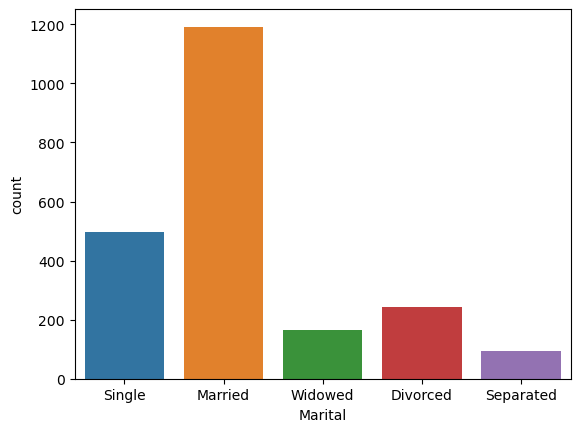

In [9]:
sns.countplot(data = df, x = 'Marital')

The most frequent datapoint is 'Married'. We can fill the nulls with unknown, since this is not ordinal data. 

<AxesSubplot: xlabel='Marital', ylabel='count'>

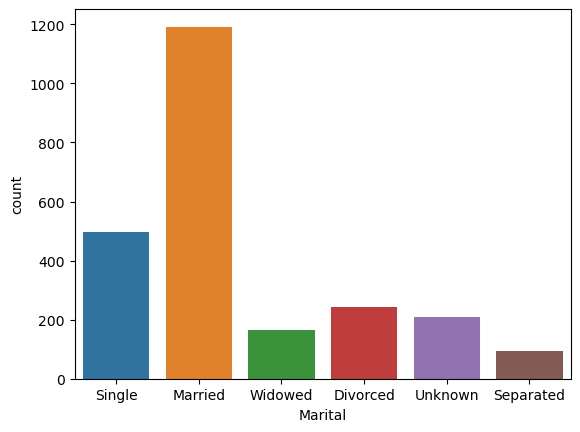

In [10]:
df['Marital'].fillna('Unknown', inplace = True)
sns.countplot(data = df, x = 'Marital')

Marital is handled, lets take a look at Income

In [11]:
df['Income'].describe()

count    2284.000000
mean     4005.253940
std      2954.032186
min       300.000000
25%      1600.000000
50%      2500.000000
75%      6200.000000
max      9000.000000
Name: Income, dtype: float64

<AxesSubplot: xlabel='Income', ylabel='Count'>

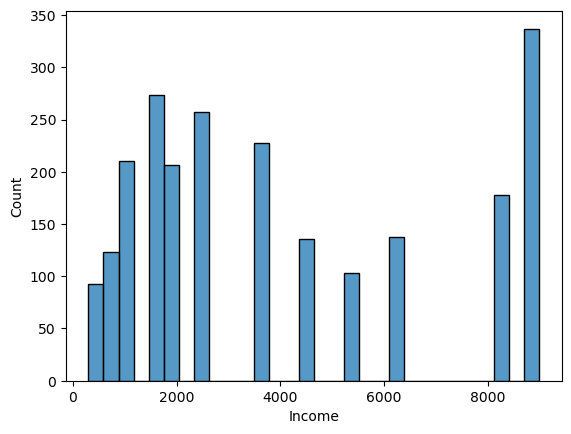

In [12]:
sns.histplot(data = df, x = 'Income', bins = 30)

<AxesSubplot: ylabel='Income'>

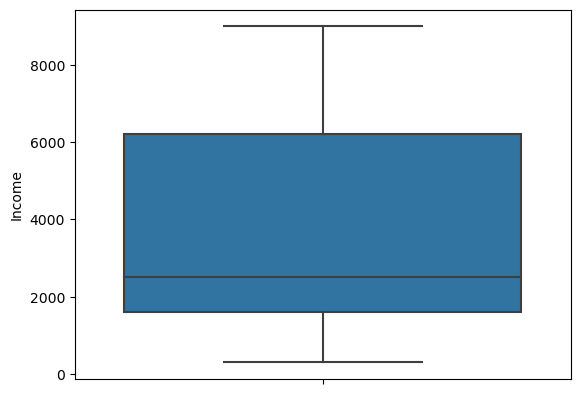

In [13]:
sns.boxplot(data = df, y = 'Income')

Income is pretty spread out. The mean for income is much higher than the median as well. There is a big disparity between the min and max, but both have a substantial amount of volume. I think I can fill this with the mean, since 4005 is a close middle point between the min and max.

In [14]:
df['Income'].fillna(df['Income'].mean(), inplace = True)
df['Income'].describe()

count    2401.000000
mean     4005.253940
std      2881.128031
min       300.000000
25%      1600.000000
50%      3500.000000
75%      6200.000000
max      9000.000000
Name: Income, dtype: float64

Up next is WaistCirc

count    2316.000000
mean       98.307254
std        16.252634
min        56.200000
25%        86.675000
50%        97.000000
75%       107.625000
max       176.000000
Name: WaistCirc, dtype: float64

<AxesSubplot: xlabel='WaistCirc', ylabel='Count'>

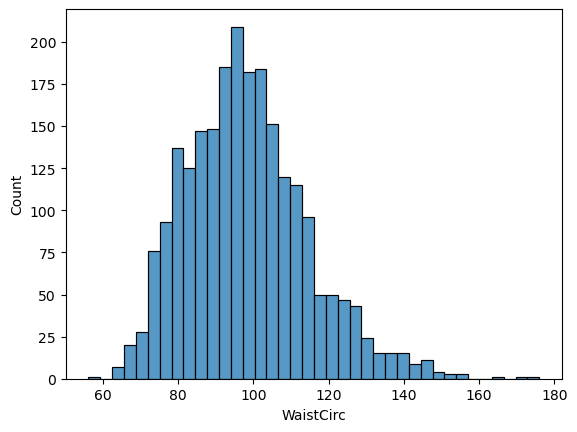

In [15]:
display(df['WaistCirc'].describe())
sns.histplot(data = df, x = 'WaistCirc')

<AxesSubplot: ylabel='WaistCirc'>

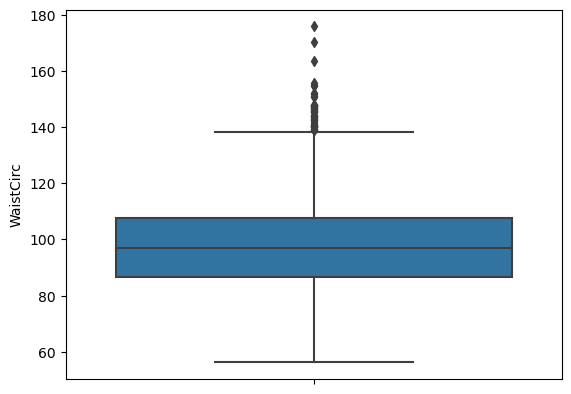

In [16]:
sns.boxplot(data = df, y= 'WaistCirc')

WaistCirc has some outliers at the higher end. These values could cause me issues when scaling the data, so I want to standardize them down and then fill the nulls with the mean. 

For now, I will just fill the nulls with the mean.

In [17]:
df['WaistCirc'].fillna(df['WaistCirc'].mean(), inplace = True)

count    2401.000000
mean       98.307254
std        15.962233
min        56.200000
25%        87.000000
50%        97.500000
75%       107.200000
max       176.000000
Name: WaistCirc, dtype: float64

<AxesSubplot: ylabel='WaistCirc'>

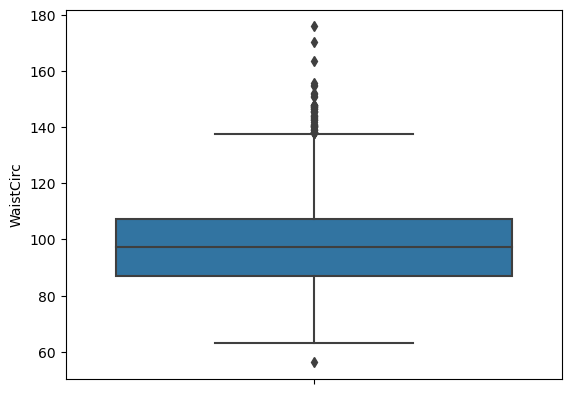

In [18]:
display(df['WaistCirc'].describe())
sns.boxplot(data = df, y= 'WaistCirc')

BMI is the last one, lets take a look

count    2375.000000
mean       28.702189
std         6.662242
min        13.400000
25%        24.000000
50%        27.700000
75%        32.100000
max        68.700000
Name: BMI, dtype: float64

<AxesSubplot: ylabel='BMI'>

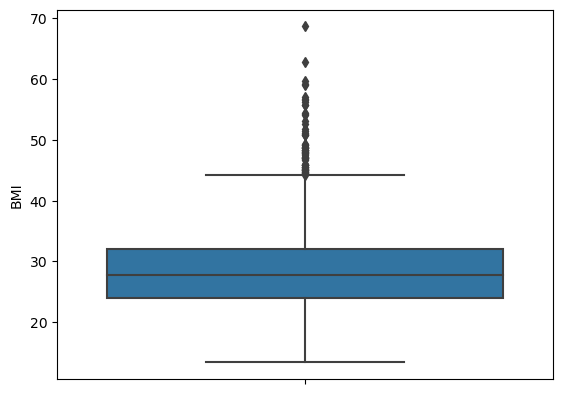

In [19]:
display(df['BMI'].describe())
sns.boxplot(data = df, y= 'BMI')

<AxesSubplot: xlabel='BMI', ylabel='Count'>

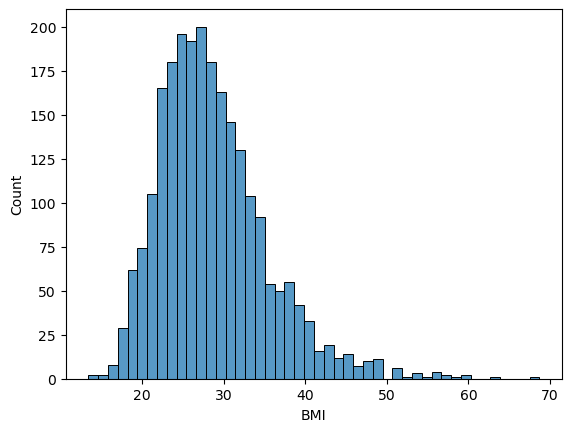

In [20]:
sns.histplot(data = df, x = 'BMI')

Similar story here for BMI and WaistCirc. I'm sure there is some correlation between these two metrics, but we will dig into that later. For now, lets replace the nulls with the mean. We will deal with outliers at a later step to keep the steps consistent

count    2401.000000
mean       28.702189
std         6.626057
min        13.400000
25%        24.000000
50%        27.800000
75%        32.000000
max        68.700000
Name: BMI, dtype: float64

<AxesSubplot: ylabel='BMI'>

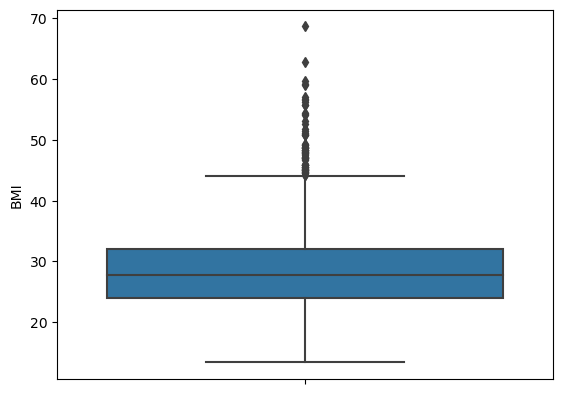

In [21]:
df['BMI'].fillna(df['BMI'].mean(), inplace = True)
display(df['BMI'].describe())
sns.boxplot(data = df, y= 'BMI')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2401 non-null   object 
 3   Income             2401 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2401 non-null   float64
 6   BMI                2401 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


## Outliers and Inconsistencies
Empty values have been fixed. Lets take a look at the numerical columns for inconsistencies and outliers. First, lets create some functions. I want to make:
* A function to plot and describe Numerical Data
* A function to plot and describe Categorical Data
* A function to replace Outliers

### Numerical

In [23]:
# Creating a function for Numerical data analysis
def numdata(data, columns):
    """This function prints out a Statistical description of the column in a dataframe
    and plots a histogram and boxplot of the data"""
    # .describe()
    print(f'Statistical Description: \n {data[columns].describe()} \n')
    
    # Box and Hist plots
    figmain, axmain = plt.subplots(ncols = 2, figsize =(16,4))

    sns.histplot(data = data, x = columns, ax = axmain[0])
    axmain[0].set_title(f'Histogram distribution for {columns}', fontsize = 12)
    
    sns.boxplot(data = data, x = columns, ax = axmain[1])
    axmain[1].set_title(f'Boxplot Distribution for {columns}', fontsize = 12)
    
    figmain.suptitle(f'Hist & Boxplot for {columns}', fontsize = 18)
    figmain.tight_layout()  
    
# Creating a function for Categorical data analysis    
def catdata(data, columns):
    """This function prints the value counts and a Statistical description of the column
    in a dataframe, and plots a countplot of the data."""
    # .value_counts() and .describe()
    print(f'Count of Values: \n{data[columns].value_counts()} \n')
    print(f'Statistical Description: \n {data[columns].describe()}')
    
    # Countplot
    labelorder = data.value_counts(subset = columns).index
    figmain, axmain = plt.subplots(figsize =(8,4))

    sns.countplot(data = data, y = columns, order = labelorder)
    axmain.set_title(f'Counts for {columns}', fontsize = 12)

In [24]:
# Creating a function to calculate outlier ranges
def get_outliers(data, column):
    """This function returns the top and bottom values for outliers for the column in a 
    dataset using Q1 - 1.5*IQR and Q3 + 1.5*IQR"""
    Q1 = data[column].quantile(.25)
    Q3 = data[column].quantile(.75)
    IQR = Q3 - Q1
    topouts = Q3 + 1.5*IQR
    bottomouts = Q1 - 1.5*IQR
    return topouts, bottomouts

# Creating a function to replace Outliers
def replace_outliers(data, column = []):
    """This function uses the prior function to calculate the outlier cutoffs, and
    replaces any values above or below that value with the cutoff"""
    for i in column:
        top, bottom = get_outliers(data, i)
        df.loc[(df[i] < bottom), i] = bottom
        df.loc[(df[i] > top), i] = top
    return None

Statistical Description: 
 count    2401.000000
mean       48.691795
std        17.632852
min        20.000000
25%        34.000000
50%        48.000000
75%        63.000000
max        80.000000
Name: Age, dtype: float64 



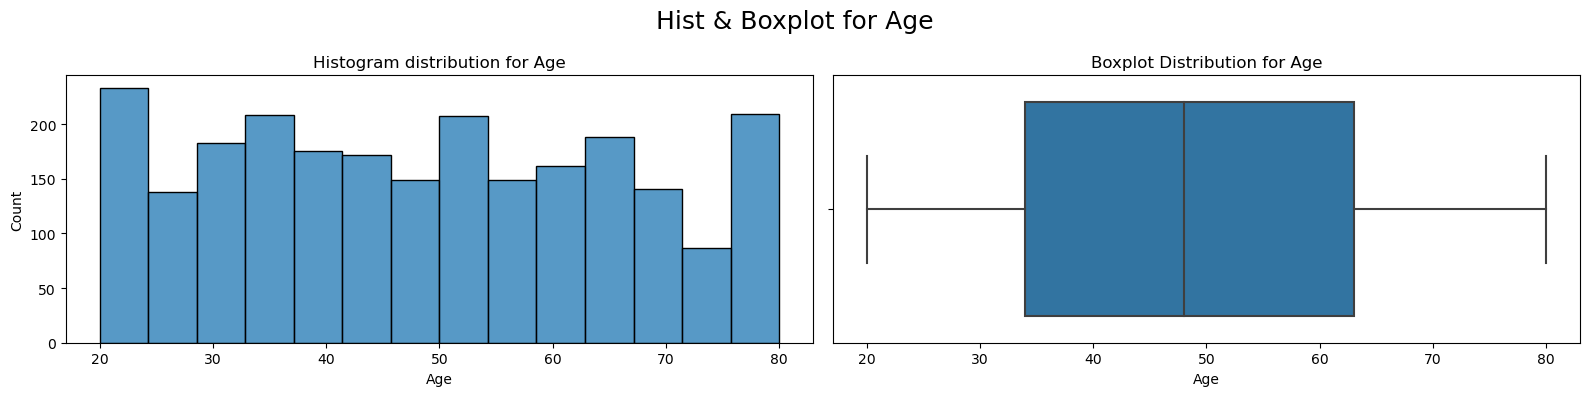

In [25]:
numdata(df, 'Age')

Age looks good. No outliers

Statistical Description: 
 count    2401.000000
mean     4005.253940
std      2881.128031
min       300.000000
25%      1600.000000
50%      3500.000000
75%      6200.000000
max      9000.000000
Name: Income, dtype: float64 



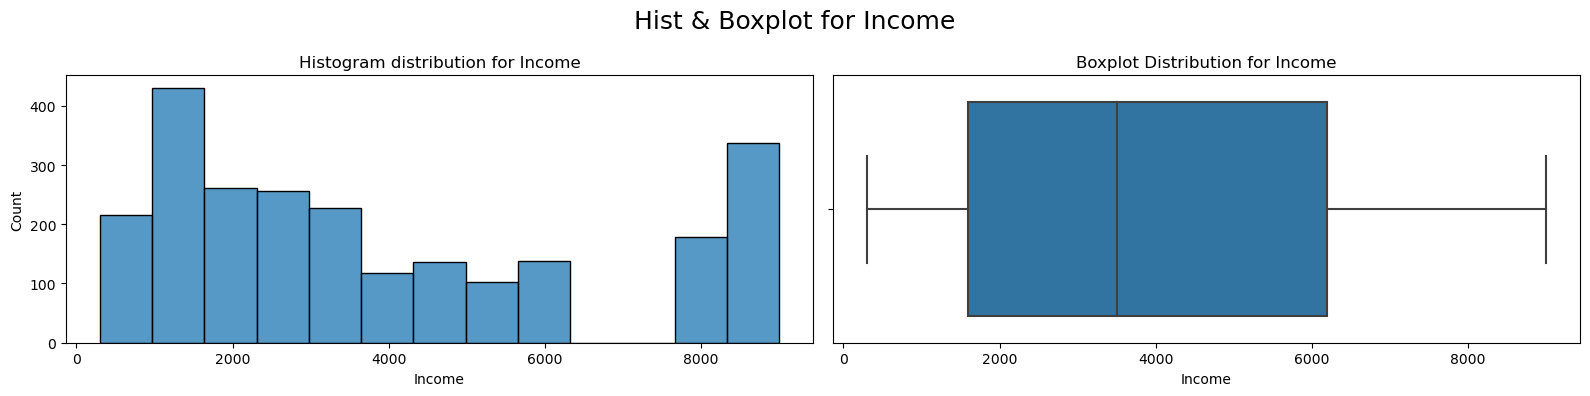

In [26]:
numdata(df, 'Income')

Income is good with no Outliers

Statistical Description: 
 count    2401.000000
mean       98.307254
std        15.962233
min        56.200000
25%        87.000000
50%        97.500000
75%       107.200000
max       176.000000
Name: WaistCirc, dtype: float64 



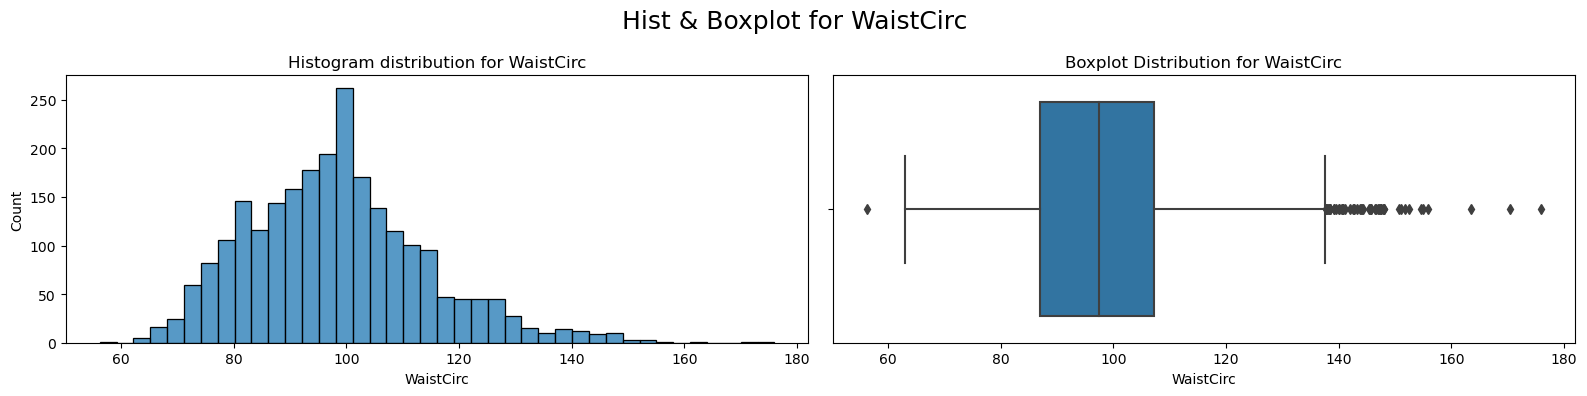

In [27]:
numdata(df, 'WaistCirc')

WaistCirc has some outliers. Lets fix that with the function I created earlier

Statistical Description: 
 count    2401.000000
mean       98.130369
std        15.430587
min        56.700000
25%        87.000000
50%        97.500000
75%       107.200000
max       137.500000
Name: WaistCirc, dtype: float64 



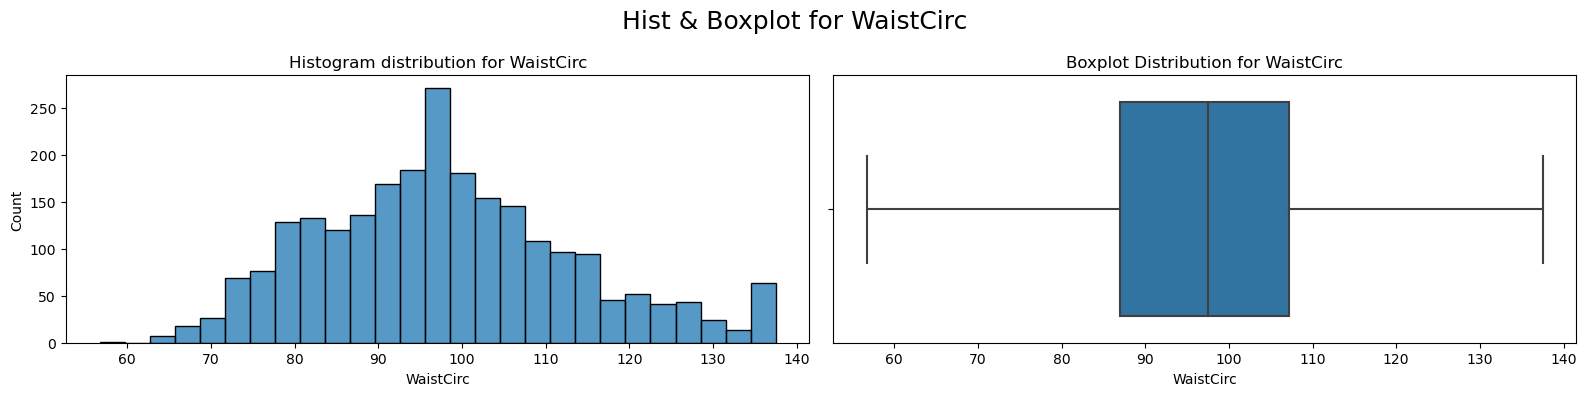

In [28]:
replace_outliers(df, ['WaistCirc'])
numdata(df,'WaistCirc')

Statistical Description: 
 count    2401.000000
mean       28.702189
std         6.626057
min        13.400000
25%        24.000000
50%        27.800000
75%        32.000000
max        68.700000
Name: BMI, dtype: float64 



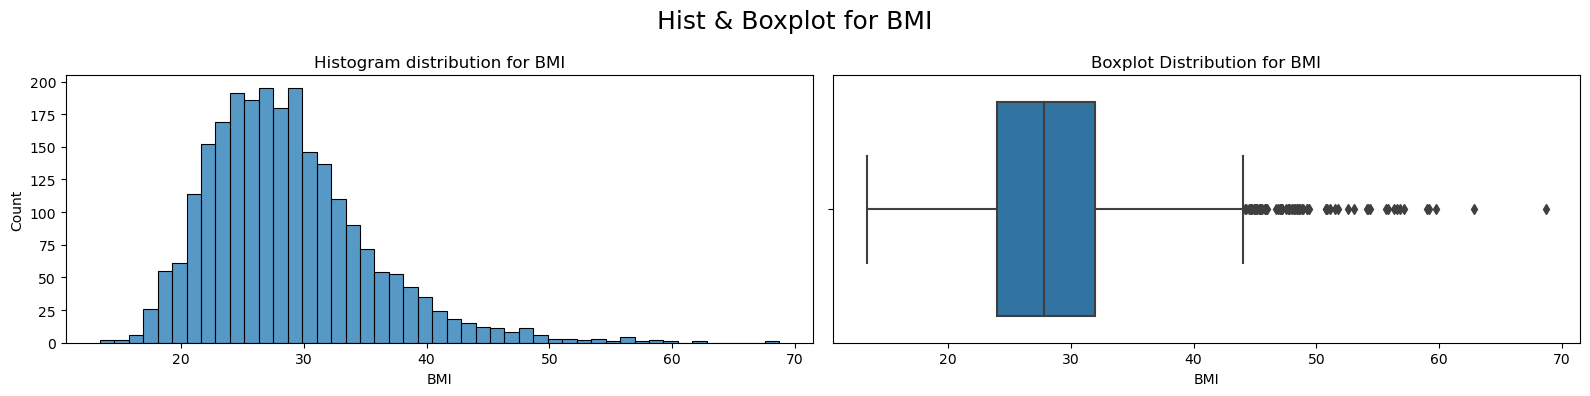

In [29]:
numdata(df, 'BMI')

BMI has some outliers, lets clean them up

Statistical Description: 
 count    2401.000000
mean       28.543672
std         6.118412
min        13.400000
25%        24.000000
50%        27.800000
75%        32.000000
max        44.000000
Name: BMI, dtype: float64 



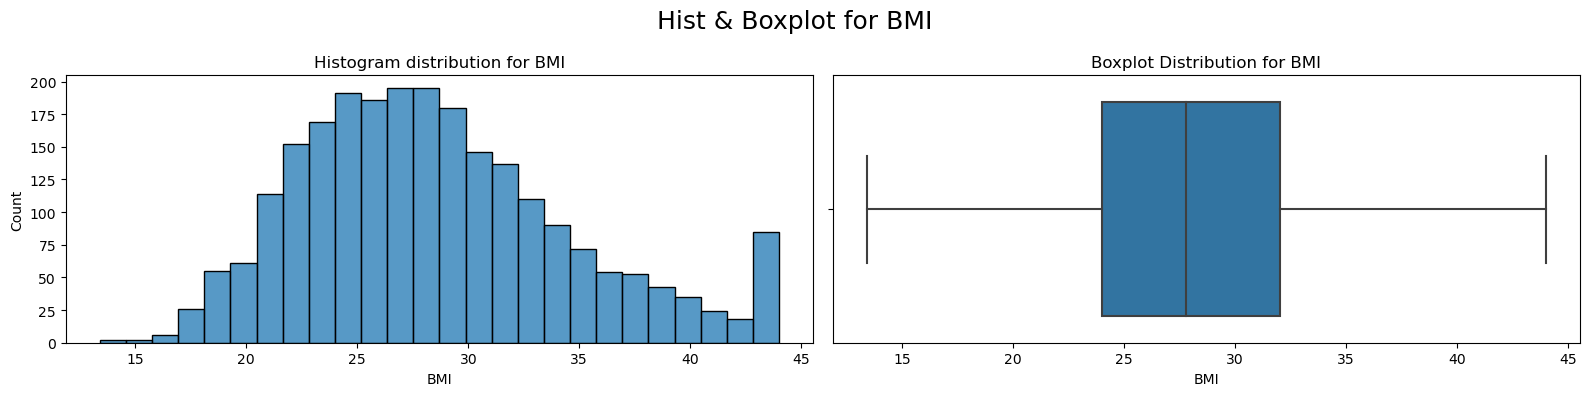

In [30]:
replace_outliers(df, ['BMI'])
numdata(df, 'BMI')

Statistical Description: 
 count    2401.000000
mean        0.154102
std         0.422780
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Albuminuria, dtype: float64 



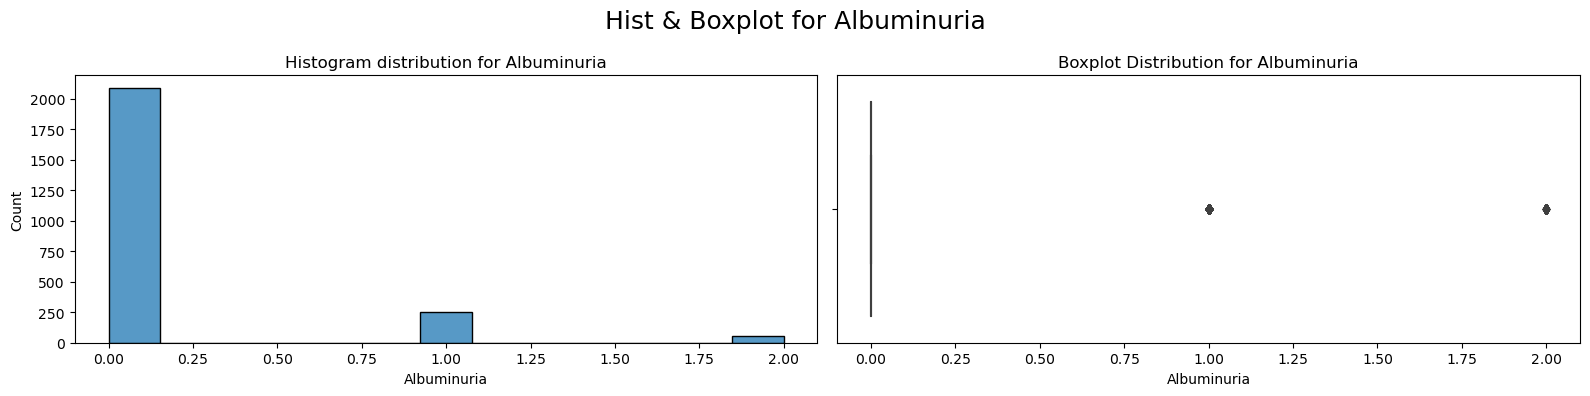

In [31]:
numdata(df, 'Albuminuria')

This column does not appear to actually be a numeric column. Albuminuria is a condition where the protein albumin is abnormally present in the urine. Lets run a value count on this instead

In [32]:
df['Albuminuria'].value_counts()

0    2089
1     254
2      58
Name: Albuminuria, dtype: int64

There is no description on this column in the data source, so I will make an assumption that this column is categorical column. According to [kidney.org](https://www.kidney.org/content/kidney-failure-risk-factor-urine-albumin-to-creatinine-ration-uacr) Albuminuria comes in 3 categories. I will confirm these categories by comparing this value to UrAlbCr, which I believe may be the Albumin-Creatinine Ratio

0    2089
1     254
2      58
Name: Albuminuria, dtype: int64

<AxesSubplot: xlabel='Albuminuria', ylabel='count'>

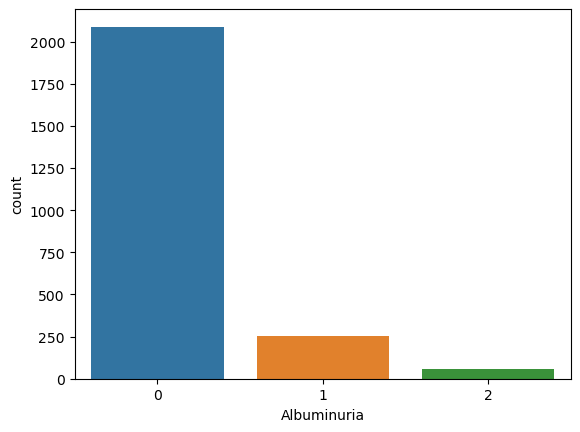

In [33]:
display(df['Albuminuria'].value_counts())
sns.countplot(data = df, x = 'Albuminuria')

Statistical Description: 
 count    2401.000000
mean       43.626131
std       258.272829
min         1.400000
25%         4.450000
50%         7.070000
75%        13.690000
max      5928.000000
Name: UrAlbCr, dtype: float64 



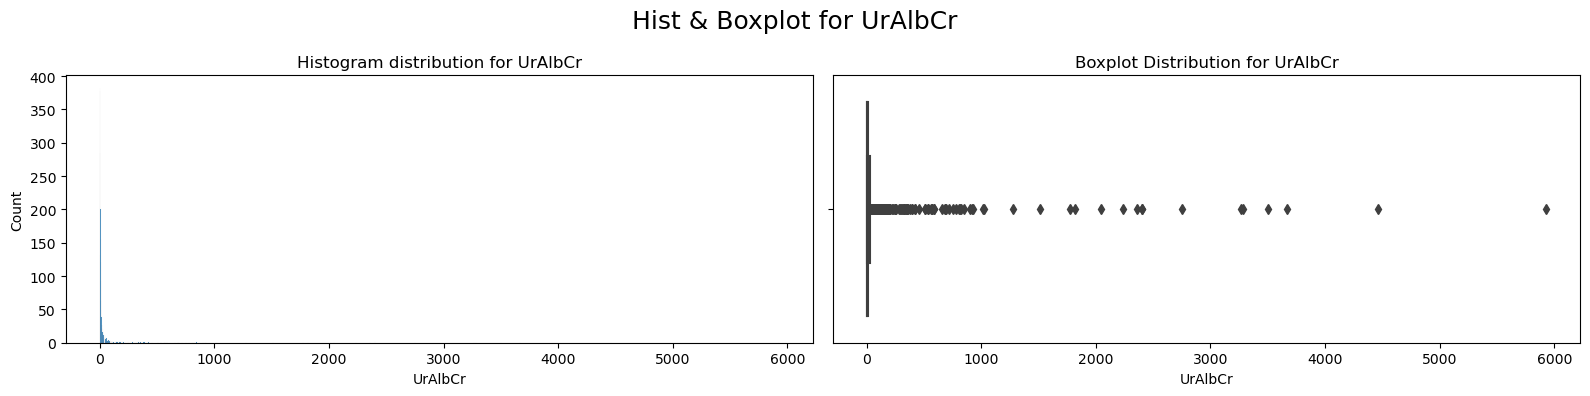

In [34]:
numdata(df, 'UrAlbCr')

Based on some research, I think UrAlbCr must be the Urine Albumin-Creatinine Ratio. I am going to dig into this to make sure this hypothesis is atleast plausible in the data. I want to check if Albuminuria categories match the UrAlbCr numbers. It should be:
* Albuminuria = 0 is < 30
* Albuminuria = 1 is < 300
* Albuminuria = 2 is > 300

<AxesSubplot: xlabel='UrAlbCr', ylabel='Albuminuria'>

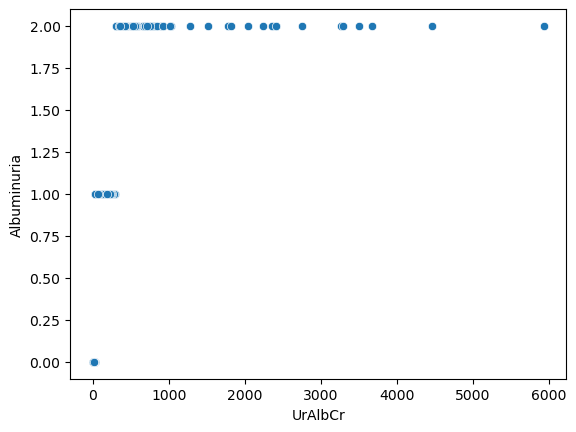

In [35]:
sns.scatterplot(data = df, x = 'UrAlbCr', y = 'Albuminuria')

In [36]:
print('Albuminuria = 0 \n')
display(df.loc[(df['Albuminuria'] == 0),'UrAlbCr'].describe())
print('Albuminuria = 1 \n')
display(df.loc[(df['Albuminuria'] == 1),'UrAlbCr'].describe())
print('Albuminuria = 2 \n')
display(df.loc[(df['Albuminuria'] == 2),'UrAlbCr'].describe())

Albuminuria = 0 



count    2089.000000
mean        8.100282
std         5.688320
min         1.400000
25%         4.190000
50%         6.240000
75%        10.060000
max        29.820000
Name: UrAlbCr, dtype: float64

Albuminuria = 1 



count    254.000000
mean      74.751496
std       53.439890
min       30.000000
25%       37.742500
50%       53.685000
75%       90.447500
max      289.720000
Name: UrAlbCr, dtype: float64

Albuminuria = 2 



count      58.000000
mean     1186.861552
std      1189.233401
min       301.050000
25%       421.935000
50%       686.735000
75%      1452.482500
max      5928.000000
Name: UrAlbCr, dtype: float64

This is correct. Albuminuria is an Ordinal column and it matches the values we should expect to see. I will not fix any outliers for UrAlbCr since it is part of an ordinal column

Statistical Description: 
 count    2401.000000
mean        5.489046
std         1.439358
min         1.800000
25%         4.500000
50%         5.400000
75%         6.400000
max        11.300000
Name: UricAcid, dtype: float64 



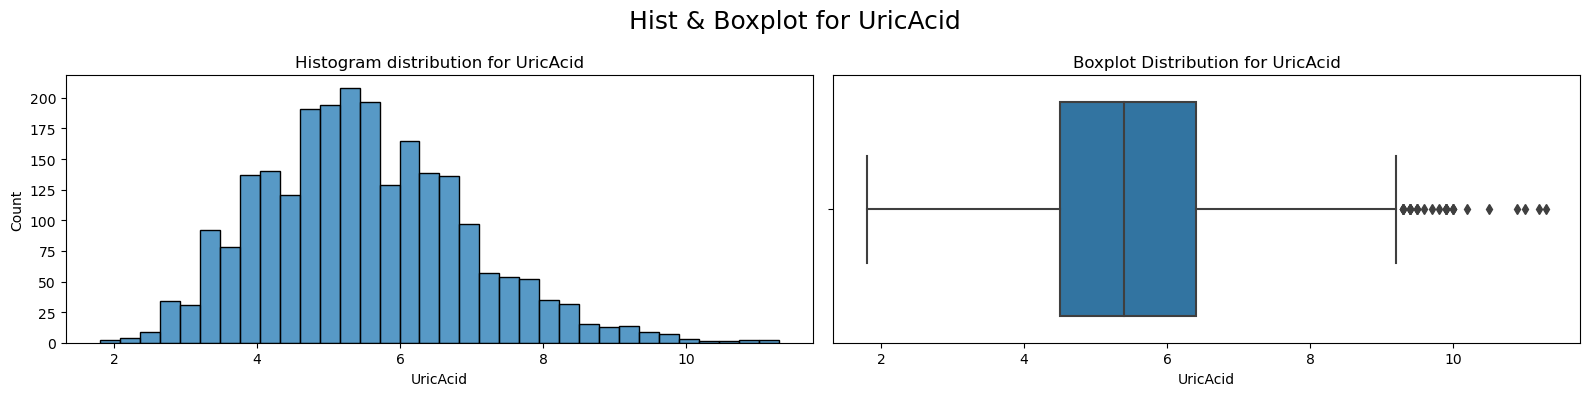

In [37]:
numdata(df, 'UricAcid')

Uric Acid has some outliers with a tight distribution. [MedicalNewsToday](https://www.medicalnewstoday.com/articles/uric-acid-level#uric-acid-levels) High Uric Acid is above 7 for Males and above 6 for Females. Lets replace the outliers.

Statistical Description: 
 count    2401.000000
mean        5.481466
std         1.416299
min         1.800000
25%         4.500000
50%         5.400000
75%         6.400000
max         9.250000
Name: UricAcid, dtype: float64 



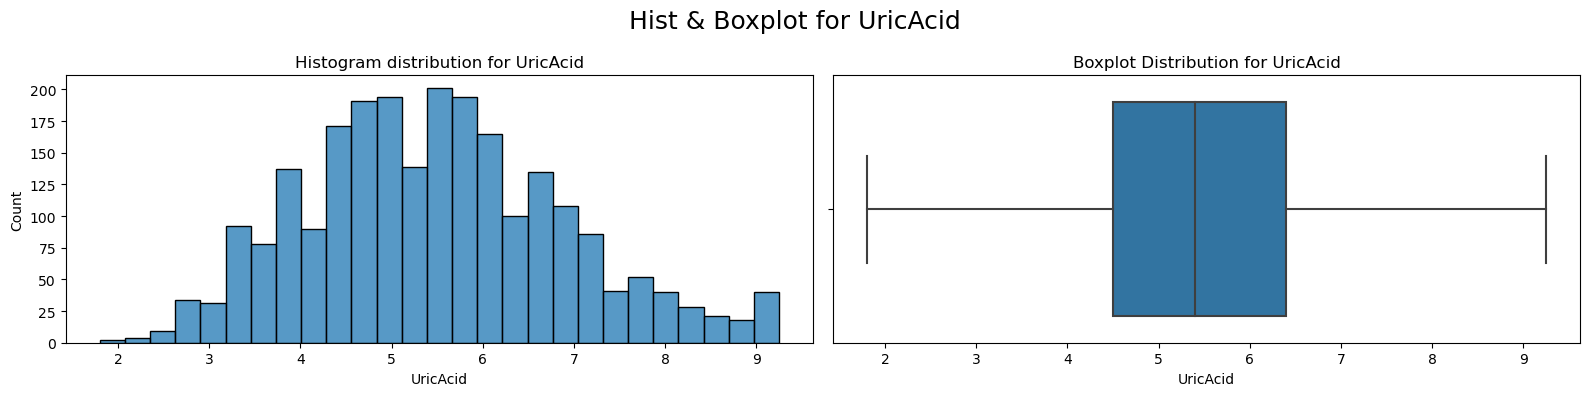

In [38]:
replace_outliers(df, ['UricAcid'])
numdata(df, 'UricAcid')

Statistical Description: 
 count    2401.000000
mean      108.247813
std        34.820657
min        39.000000
25%        92.000000
50%        99.000000
75%       110.000000
max       382.000000
Name: BloodGlucose, dtype: float64 



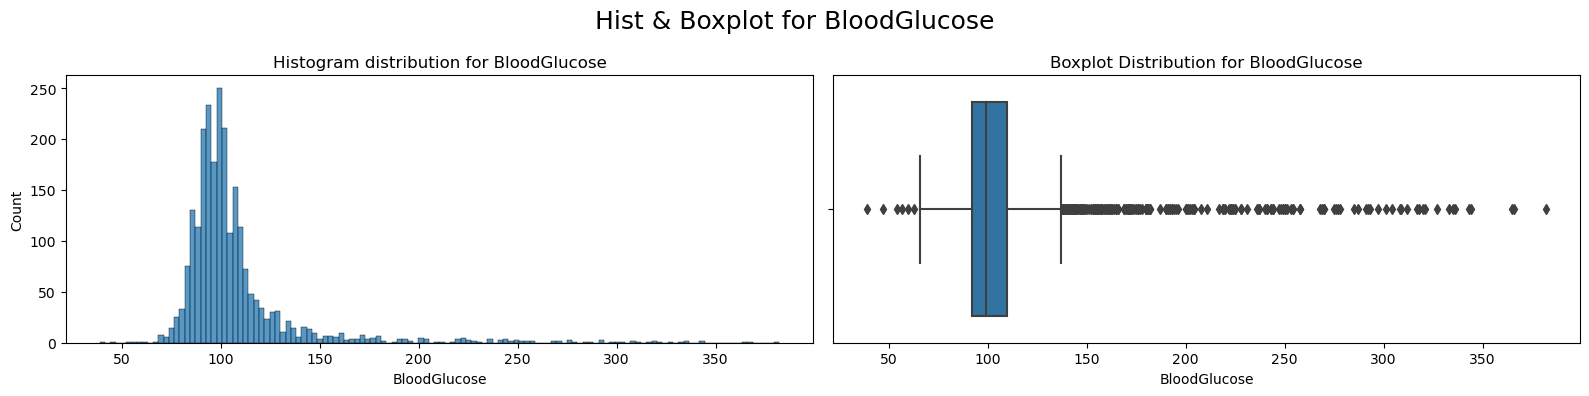

In [39]:
numdata(df, 'BloodGlucose')

In [40]:
top, bottom = get_outliers(df, 'BloodGlucose')
print(top)
df.loc[df['BloodGlucose'] > top,'BloodGlucose'].shape[0]

137.0


214

According to [Forbes health](https://www.forbes.com/health/body/normal-blood-sugar-levels/) normal fasting blood sugar levels are less than or equal to 100mg/dl. There is no info on the dataset about the unit of measure or time of measurement for BloodGlucose, I will assume that it is fasted BloodGlucose. There are outliers in this data. It makes up about 9% of the data on the high end. I will standardize these outliers, but it might make sense to create categories for this datapoint instead. For now, lets standardize

Statistical Description: 
 count    2401.000000
mean      102.908788
std        15.740037
min        65.000000
25%        92.000000
50%        99.000000
75%       110.000000
max       137.000000
Name: BloodGlucose, dtype: float64 



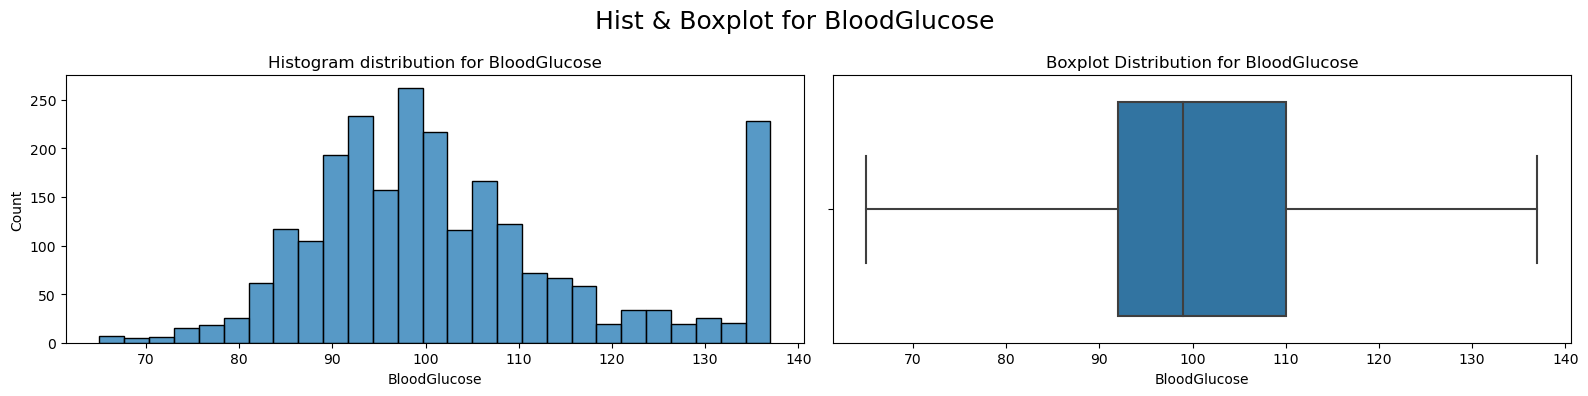

In [41]:
replace_outliers(df, ['BloodGlucose'])
numdata(df, 'BloodGlucose')

Statistical Description: 
 count    2401.000000
mean       53.369429
std        15.185537
min        14.000000
25%        43.000000
50%        51.000000
75%        62.000000
max       156.000000
Name: HDL, dtype: float64 



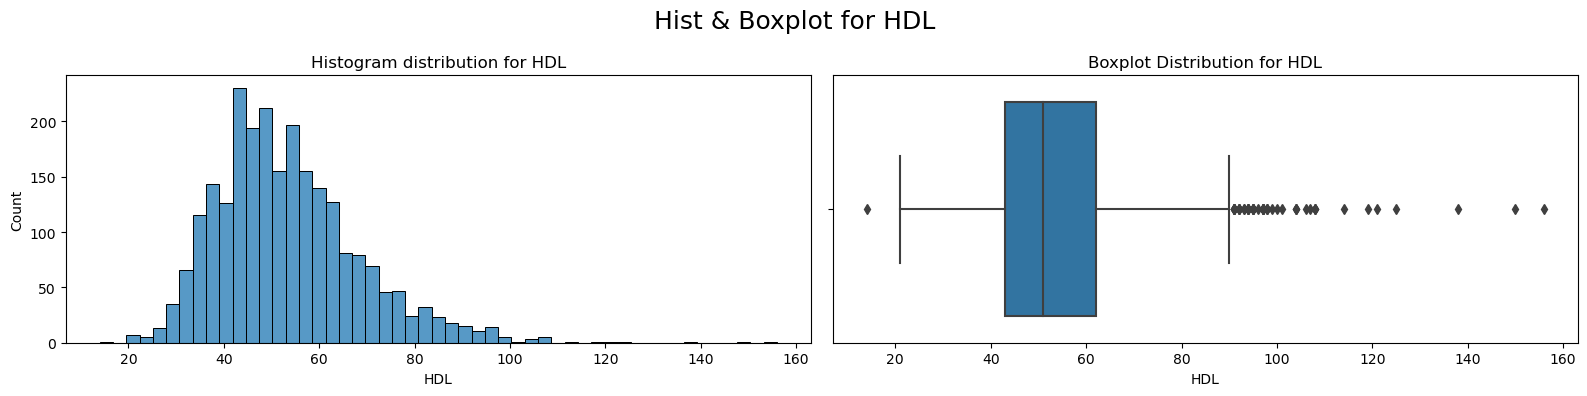

In [42]:
numdata(df, 'HDL')

Some outliers here as well, lets fix them. HDL behaves differently than other measures here. For HDL, a higher number is better. Here, a healthy adult should be at 60, but no less than 50 for Women and 40 for Men. Source: [MayoClinic](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/hdl-cholesterol/art-20046388). The mean is right around that 50 mark, and our IQR sits right around the healthy levels. 

Statistical Description: 
 count    2401.000000
mean       53.129946
std        14.346950
min        14.500000
25%        43.000000
50%        51.000000
75%        62.000000
max        90.500000
Name: HDL, dtype: float64 



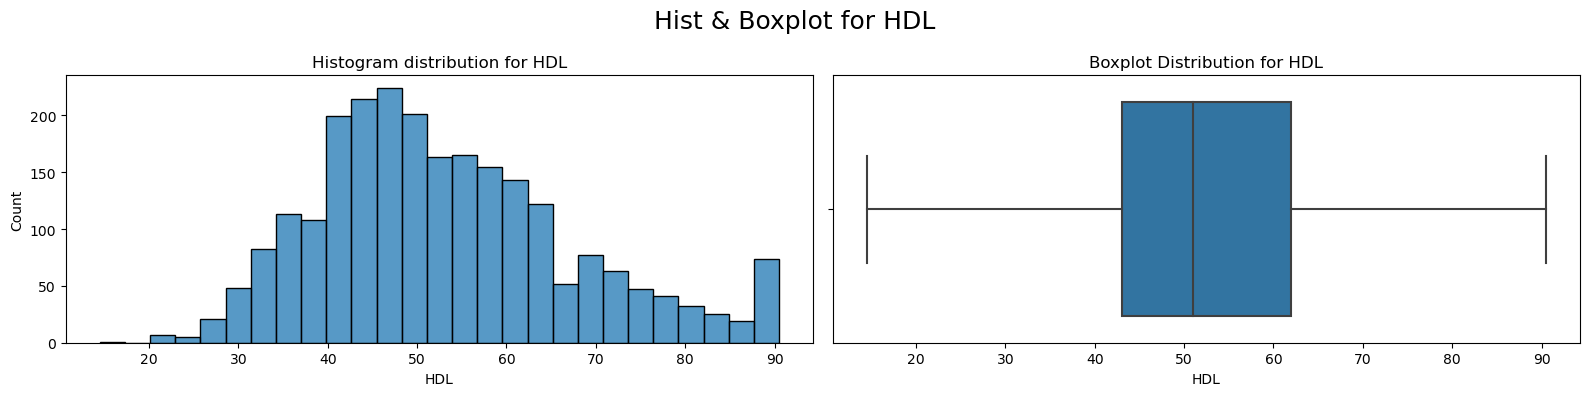

In [43]:
replace_outliers(df, ['HDL'])
numdata(df, 'HDL')

Statistical Description: 
 count    2401.000000
mean      128.125364
std        95.322477
min        26.000000
25%        75.000000
50%       103.000000
75%       150.000000
max      1562.000000
Name: Triglycerides, dtype: float64 



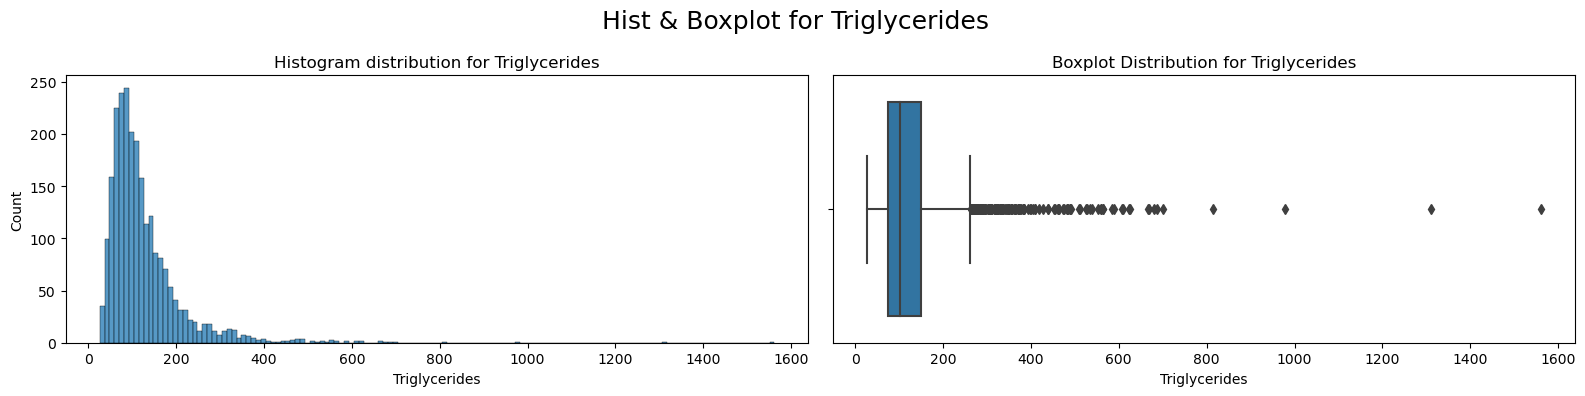

In [44]:
numdata(df,'Triglycerides')

In [45]:
top, bottom = get_outliers(df, 'Triglycerides')
top

262.5

Triglycerides have ranges, I would like to create some categories for this column instead of standardizing. the High outliers for the dataset start at 262.5, while Very High triglycerides are considered to be over 500. I will use the categories from [MayoClinic](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/triglycerides/art-20048186) for my analysis

In [46]:
df.loc[(df['Triglycerides']<150),'TriglyceridesCat'] = 0
df.loc[(df['Triglycerides']>=150) & (df['Triglycerides']<200),'TriglyceridesCat'] = 1
df.loc[(df['Triglycerides']>=200) & (df['Triglycerides']<500),'TriglyceridesCat'] = 2
df.loc[(df['Triglycerides']>=500),'TriglyceridesCat'] = 3

In [47]:
df['TriglyceridesCat'].value_counts()

0.0    1800
1.0     309
2.0     266
3.0      26
Name: TriglyceridesCat, dtype: int64

### Categorical
This concludes our Numerical Data. Now lets take a look at Categorical, including Ordinal

Count of Values: 
0.0    1800
1.0     309
2.0     266
3.0      26
Name: TriglyceridesCat, dtype: int64 

Statistical Description: 
 count    2401.000000
mean        0.382757
std         0.723201
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: TriglyceridesCat, dtype: float64


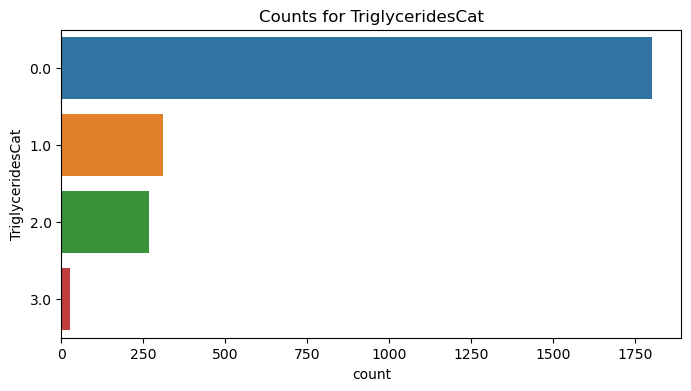

In [48]:
catdata(df, 'TriglyceridesCat')

Count of Values: 
0    1579
1     822
Name: MetabolicSyndrome, dtype: int64 

Statistical Description: 
 count    2401.000000
mean        0.342357
std         0.474597
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: MetabolicSyndrome, dtype: float64


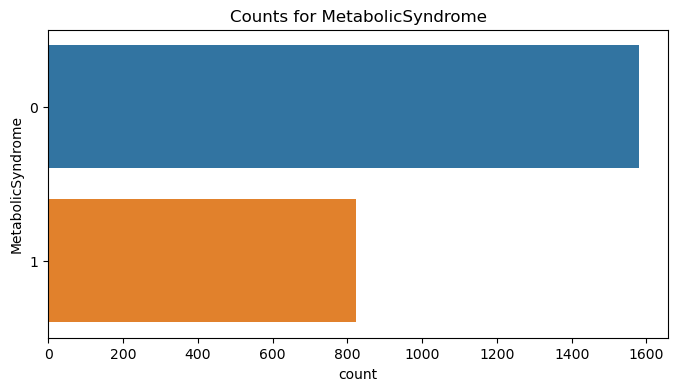

In [49]:
catdata(df, 'MetabolicSyndrome')

Count of Values: 
Female    1211
Male      1190
Name: Sex, dtype: int64 

Statistical Description: 
 count       2401
unique         2
top       Female
freq        1211
Name: Sex, dtype: object


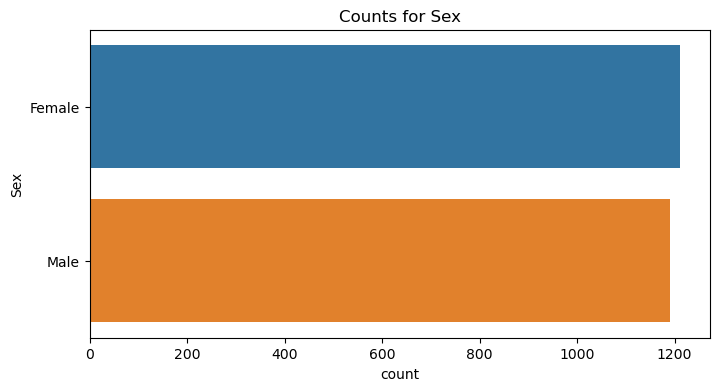

In [50]:
catdata(df, 'Sex')

Consistent values, we see that there is a good balance between Male and Female, althought we have slightly more Females than Males in the dataset

Count of Values: 
Married      1192
Single        498
Divorced      242
Unknown       208
Widowed       166
Separated      95
Name: Marital, dtype: int64 

Statistical Description: 
 count        2401
unique          6
top       Married
freq         1192
Name: Marital, dtype: object


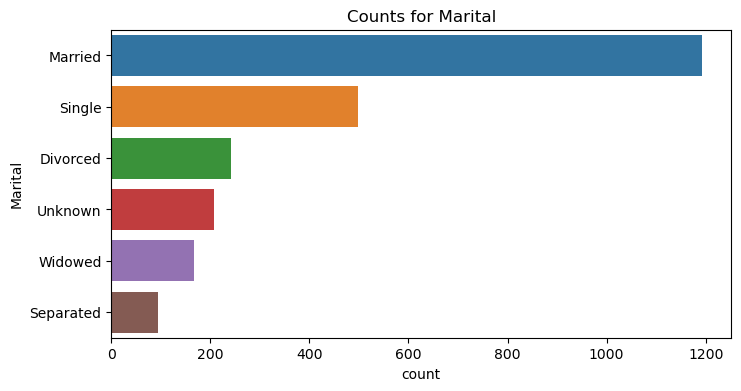

In [51]:
catdata(df, 'Marital')

Consistent, We reviewed this column when cleaning for empty values

Count of Values: 
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64 

Statistical Description: 
 count      2401
unique        6
top       White
freq        933
Name: Race, dtype: object


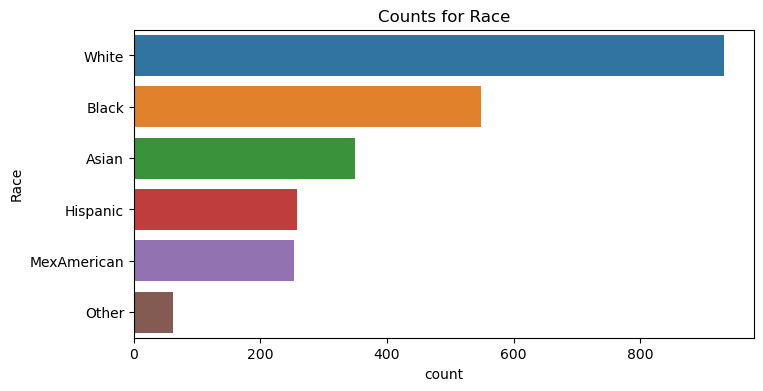

In [52]:
catdata(df, 'Race')

This column is consistent. The dataset is comprised mainly of White people. MexAmerican is an odd category, it might make sense to combine it into Hispanic. But I will leave it for now.

This concludes our initial Data Cleaning and Exploration!